In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
train_dataset = pd.read_csv('data/poem_train_data.csv')
train_dataset.head()

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [25]:
# drop na vals
train_dataset = train_dataset.dropna()

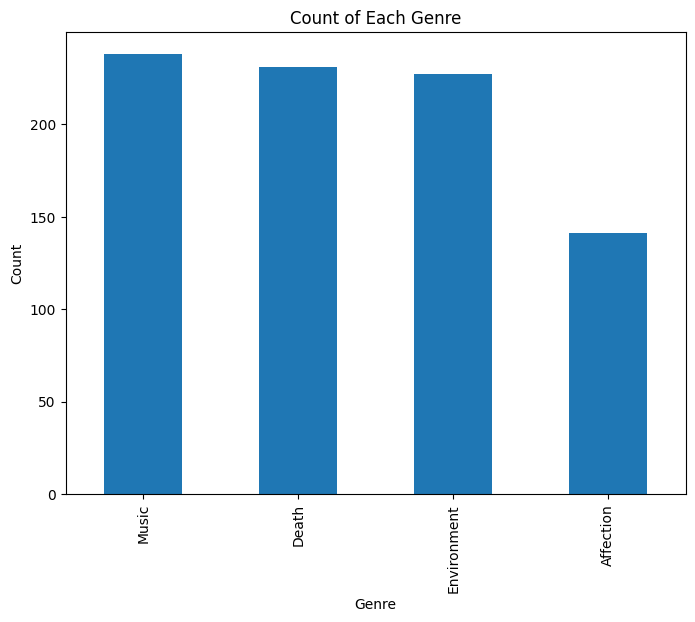

In [26]:
genre_counts = train_dataset['Genre'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
genre_counts.plot(kind='bar')

# Set title and labels
plt.title('Count of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')

# Show plot
plt.show()

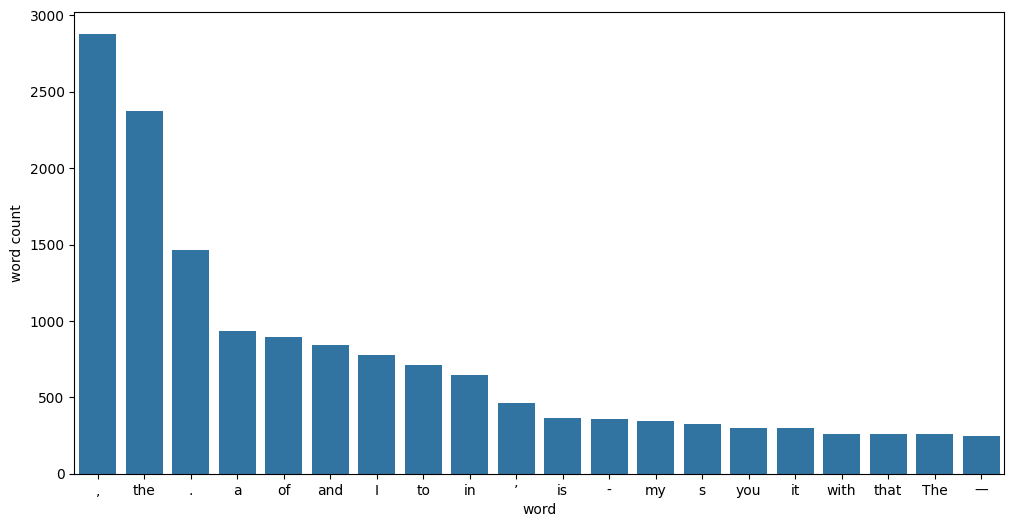

In [36]:

def get_all_words(all_text):
    all_words = ''.join([text for text in all_text])
    return all_words

def visualize_token_frequency(all_text, n_largest):
    all_words = get_all_words(all_text)
    tokenizer = tokenize.WordPunctTokenizer()
    tokenized_data = tokenizer.tokenize(all_words)
    frequency = nltk.FreqDist(tokenized_data)
    frequency_df = pd.DataFrame({
        'word': list(frequency.keys()),
        'frequency': list(frequency.values())
    })
    plt.figure(figsize=(12,6))
    ax = sns.barplot(
        data = frequency_df.nlargest(n_largest, 'frequency'),
        x = 'word',
        y = 'frequency'
    )
    ax.set(ylabel = 'word count')
    plt.show()
visualize_token_frequency(train_dataset['Poem'], 20)

In [33]:
# need to get rid of punctuation and relatively meaningless words (nltk stopwords)
def clean_words(dataset, column_name, stopwords):
    remove_special_chars = re.compile(r'[^a-zA-z\s]')
    tokenizer = tokenize.WordPunctTokenizer()
    cleaned_poems = []
    for text in dataset[column_name]:
        clean_text = remove_special_chars.sub(r'', text)
        tokenized_data = tokenizer.tokenize(clean_text)
        cleaned_words = []
        for token in tokenized_data:
            token = token.lower()
            if token not in stopwords:
                cleaned_words.append(token)
        cleaned_text = ' '.join(cleaned_words)
        cleaned_poems.append(cleaned_text)
    dataset['cleaned_poems'] = cleaned_poems

stopwords = nltk.corpus.stopwords.words("english")
clean_words(train_dataset, 'Poem', stopwords)
train_dataset.head()

/var/folders/4v/hcqt1p7s1859vr42874pyy8r0000gn/T/ipykernel_17778/1263678895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cleaned_poems'] = cleaned_poems


,Genre,Poem,cleaned_poems
1,Music,In the thick brushthey spend the...,thick brushthey spend hottest part day soaking...
2,Music,Storms are generous. ...,storms generous something easy surrender sitti...
3,Music,—After Ana Mendieta Did you carry around the ...,ana mendieta carry around matin star hold fore...
4,Music,for Aja Sherrard at 20The portent may itself ...,aja sherrard portent may memory wallace steven...
5,Music,"for Bob Marley, Bavaria, November 1980 Here i...",bob marley bavaria november brilliant morning ...


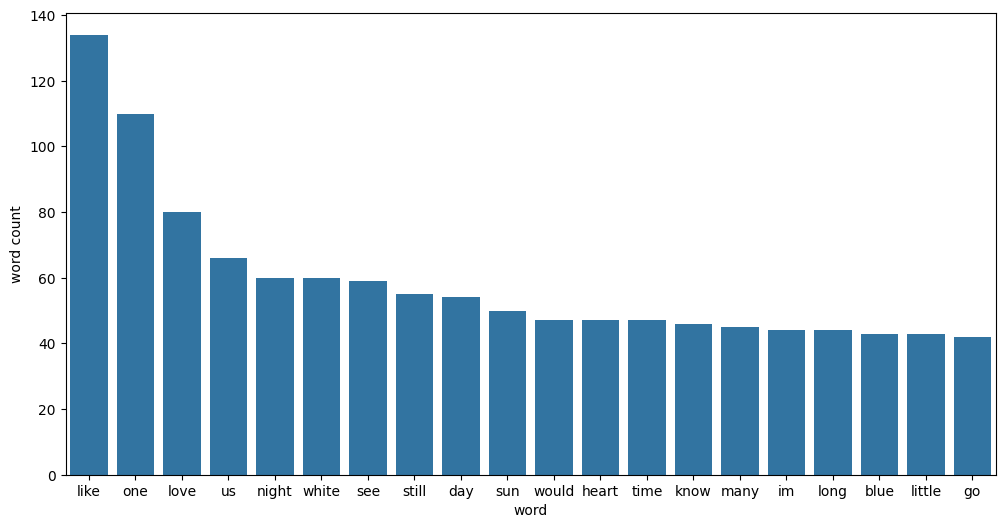

In [37]:
visualize_token_frequency(train_dataset['cleaned_poems'], 20)

In [40]:
# add stemming using nltk, ie running --> run

def stemming(dataset, column_name):
    stemmer = nltk.stem.PorterStemmer()
    tokenizer = tokenize.WordPunctTokenizer()
    stemmed_poems = []
    for text in dataset[column_name]:
        tokenized_text = tokenizer.tokenize(text)
        stemmed_tokens = []
        for token in tokenized_text:
            stemmed_tokens.append(stemmer.stem(token))
        stemmed_text = ' '.join(stemmed_tokens)
        stemmed_poems.append(stemmed_text)
    dataset['stemmed_poems'] = stemmed_poems
stemming(train_dataset, 'cleaned_poems')


/var/folders/4v/hcqt1p7s1859vr42874pyy8r0000gn/T/ipykernel_17778/889224863.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['stemmed_poems'] = stemmed_poems


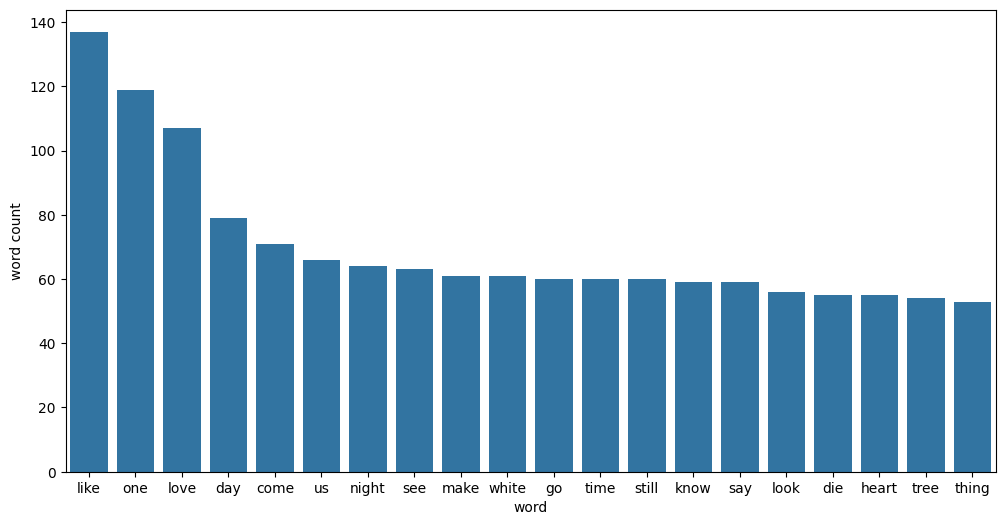

In [41]:
visualize_token_frequency(train_dataset['stemmed_poems'], 20)

In [45]:
# TF-IDF/one-hot encoding
# max_features sets top terms across all text to be used
vectorizer = TfidfVectorizer(max_features = 20)
# fit_transform turns the text into  a document-term matrix where each row represents a document, and each column represents a term.
bag_of_words = vectorizer.fit_transform(train_dataset['stemmed_poems'])
bag_of_words.shape

# now turn the bagofwords into pandas friendly
feature_names = vectorizer.get_feature_names_out()
dense_list = bag_of_words.todense().tolist()
vect_df = pd.DataFrame(dense_list, columns=feature_names)
vect_df.head()


,come,day,die,go,heart,know,like,look,love,make,night,one,say,see,still,thing,time,tree,us,white
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.755095,0.655615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
